### 1. Importing packages

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# checking gpu support
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate

In [5]:
import splitfolders
import os
import numpy as np
import pandas as pd
import random

### 2. Loading dataset

In [6]:
# defining constants
BATCH_SIZE = 20
IMG_SIZE1 = 640
IMG_SIZE2 = 480
EPOCHS = 10

In [9]:
# project's main directory
prj_dir = 'C:\\Users\\ACER1\\Music\\Tamatar ko fal'

In [10]:
# building tf input data pipeline
ds = tf.keras.utils.image_dataset_from_directory(
    f'{prj_dir}', 
    batch_size=BATCH_SIZE, 
    image_size=(IMG_SIZE1, IMG_SIZE2), 
    shuffle=True
)

Found 1600 files belonging to 2 classes.


In [11]:
# getting class names
class_names = ds.class_names
class_names

['Fal1', 'Fal2']

Batch 1 Imgs shape: (20, 640, 480, 3)
Batch 1 Lbls: [1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1]


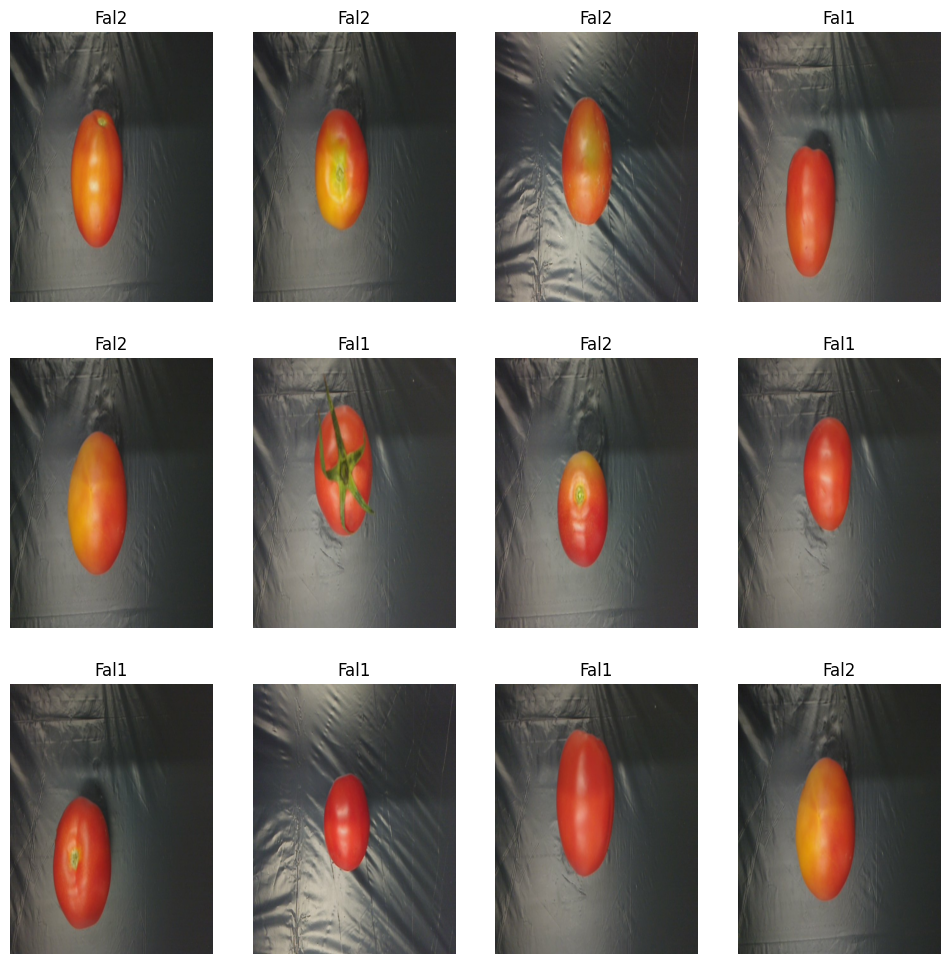

In [12]:
# displaying sample data
img = None

plt.figure(figsize=(12, 12))

for imgs, lbls in ds.take(1):
    print(f'Batch 1 Imgs shape: {imgs.shape}')
    print(f'Batch 1 Lbls: {lbls.numpy()}')

    img = imgs[0].numpy().astype('uint8') # taking sample image
    
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')

### 3. Data preprocessing

In [13]:
# creating training set, validation set and testing set
ds_size = len(ds)

ds = ds.shuffle(1600, seed=10)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 80
Train set size : 57
Val set size   : 14
Test set size  : 9


In [14]:
# optimizing tf input data pipeline performance

# caching for epochs
# prefetching tf-determined data into CPU as GPU computes - AUTOTUNE
train_set = train_set.cache().shuffle(160).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(160).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(160).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# resizing and rescaling layers
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE1, IMG_SIZE2), # during prediction
    layers.experimental.preprocessing.Rescaling(1.0 / 255) # rescaling rgb values to between 0.0 and 1.0
])

In [16]:
# data augmentation to make model robust and prevent overfitting
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'), 
    layers.experimental.preprocessing.RandomRotation(0.2)
])

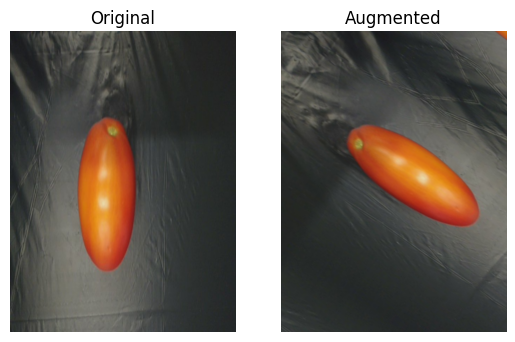

In [17]:
# testing data augmentation
imgs = [img, data_aug(img).numpy().astype('uint8')]
titles = ['Original', 'Augmented']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.axis('off')

In [18]:
# applying data augmentation to training set
train_set = train_set.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
import splitfolders
splitfolders.ratio(f'{prj_dir}', 
                   output=f'{prj_dir}', 
ratio=(.72, .18, .10)
                    )

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [21]:
train_imgs_gen = ImageDataGenerator(
    rescale=1.0 / 255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20
)

train_data_gen = train_imgs_gen.flow_from_directory(
    f'{prj_dir}/train', 
    target_size=(IMG_SIZE1, IMG_SIZE2), 
    batch_size=BATCH_SIZE, 
    class_mode='sparse',  # integer labels
    save_prefix='aug',     # corrected parameter name
    save_to_dir=f'{prj_dir}/aug_train'
)

# Similar for validation and testing sets


Found 1152 images belonging to 2 classes.


In [22]:
val_imgs_gen = ImageDataGenerator(
    rescale=1.0 / 255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20
)

val_data_gen = val_imgs_gen.flow_from_directory(
    f'{prj_dir}/val', 
    target_size=(IMG_SIZE1, IMG_SIZE2), 
    batch_size=BATCH_SIZE, 
    class_mode='sparse',  # integer labels
    save_prefix='aug',     # corrected parameter name
    save_to_dir=f'{prj_dir}/aug_val'
)

# Similar for validation and testing sets


Found 288 images belonging to 2 classes.


In [23]:
test_imgs_gen = ImageDataGenerator(
    rescale=1.0 / 255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=20
)

test_data_gen = test_imgs_gen.flow_from_directory(
    f'{prj_dir}/test', 
    target_size=(IMG_SIZE1, IMG_SIZE2), 
    batch_size=BATCH_SIZE, 
    class_mode='sparse',  # integer labels
    save_prefix='aug',     # corrected parameter name
    save_to_dir=f'{prj_dir}/aug_test'
)

# Similar for validation and testing sets


Found 160 images belonging to 2 classes.


### 4. Model building

In [24]:
# building model with alternating Conv2D and MaxPooling2D layers
input_shape = (BATCH_SIZE, IMG_SIZE1, IMG_SIZE2, 3) # 3 channels - rgb
n_classes = len(class_names)

model = models.Sequential([
    resize_rescale, # layers.InputLayer(input_shape=input_shape) # using data generator
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(), 
    layers.Dense(units=64, activation='relu'), 
    layers.Dense(units=n_classes, activation='softmax')
])

In [25]:
model.build(input_shape=input_shape)

In [26]:
model.summary() # all trainable parameters -> no transfer learning

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (20, 640, 480, 3)         0         
                                                                 
 conv2d (Conv2D)             (20, 638, 478, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (20, 319, 239, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (20, 317, 237, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (20, 158, 118, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (20, 156, 116, 64)       

In [27]:
# compiling model with optimizer, loss and metrics
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

### 5. Model fitting

In [28]:
train_dir = f'{prj_dir}/Training' # training directory

In [29]:
train_dir = os.path.join(prj_dir, 'Training')

# Check if the Training directory exists, and create it if not
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

train_ver = len(os.listdir(train_dir))
print(f'Latest saved training ver: {train_ver}')

Latest saved training ver: 0


In [30]:
cps_dir = 'training-1/cp-{epoch:04d}.ckpt' # checkpoints directory

In [31]:
# callback to save model's weights at every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cps_dir, 
    verbose=1, 
    save_weights_only=True
)

# saving weights
model.save_weights(cps_dir.format(epoch=0))

# fitting model
history = model.fit( # using data generator
    train_set, # train_data_gen
    epochs=EPOCHS, # , steps_per_epoch=train_imgs / BATCH_SIZE
    batch_size=BATCH_SIZE, 
    callbacks=[cp_callback], 
    validation_data=val_set, # validation_data=val_data_gen, validation_steps=val_imgs / BATCH_SIZE
    verbose=1
)

Epoch 1/10


57/57 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8175 
Epoch 1: saving model to training-1\cp-0001.ckpt
57/57 [==============================] - 865s 14s/step - loss: 0.4082 - accuracy: 0.8175 - val_loss: 0.1311 - val_accuracy: 0.9571
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9544 
Epoch 2: saving model to training-1\cp-0002.ckpt
57/57 [==============================] - 826s 14s/step - loss: 0.1369 - accuracy: 0.9544 - val_loss: 0.0940 - val_accuracy: 0.9750
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9544 
Epoch 3: saving model to training-1\cp-0003.ckpt
57/57 [==============================] - 881s 15s/step - loss: 0.1513 - accuracy: 0.9544 - val_loss: 0.1014 - val_accuracy: 0.9714
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9570  
Epoch 4: saving model to training-1\cp-0004.ckpt
57/57 [=====================

In [32]:
# copying checkpoints to Drive
# !cp -r training-1 '{prj_dir}/Training'

In [33]:
# getting metrics at every epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

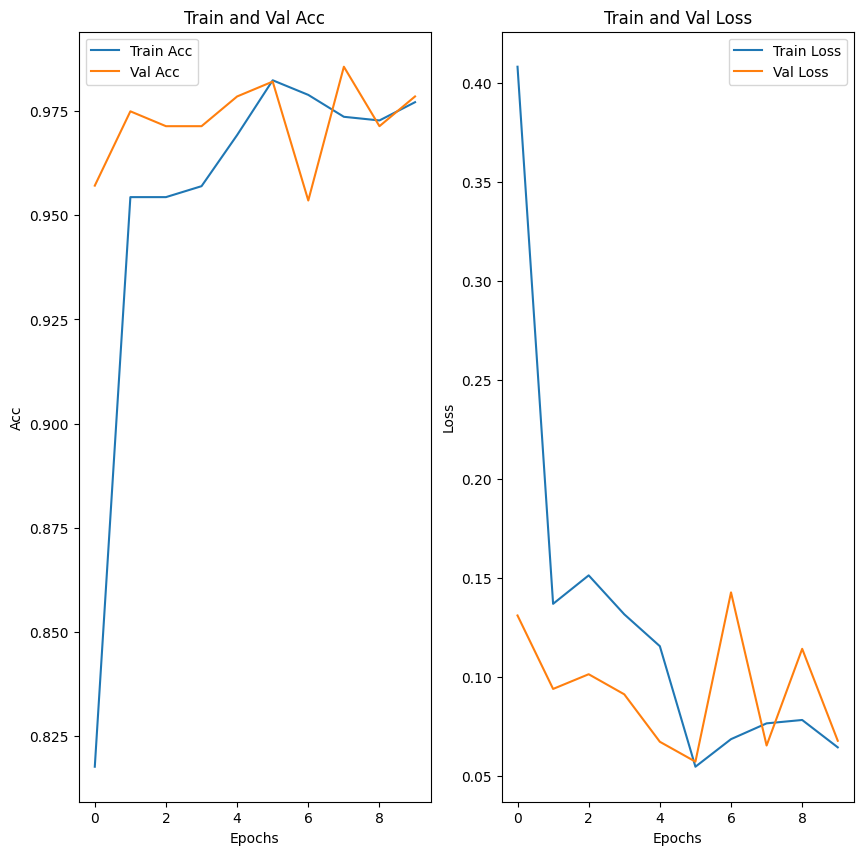

In [34]:
# plotting metrics at every epoch
train_metrics = [train_acc, train_loss]
val_metrics = [val_acc, val_loss]
metrics = ['Acc', 'Loss']

plt.figure(figsize=(10, 10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(EPOCHS), train_metrics[i], label=f'Train {metrics[i]}')
    plt.plot(range(EPOCHS), val_metrics[i], label=f'Val {metrics[i]}')
    plt.xlabel('Epochs')
    plt.ylabel(metrics[i])
    plt.title(f'Train and Val {metrics[i]}')
    plt.legend()

In [65]:
models_dir = f'C:\\Users\\ACER1\\Music\\FruitModel' # models directory
# Save the model
model.save("C:\\Users\\ACER1\\Music\\FruitModel")

INFO:tensorflow:Assets written to: C:\Users\ACER1\Music\FruitModel\assets


INFO:tensorflow:Assets written to: C:\Users\ACER1\Music\FruitModel\assets


In [66]:
# loading model if saved model is available
model = models.load_model(f'{models_dir}')

In [67]:
# loading weights if saved training is available
# cps_dir = f'C:\\Users\\ACER1\\Music\\training-1'

# latest_cp = tf.train.latest_checkpoint(os.path.dirname(cps_dir))
# model.load_weights(latest_cp) # latest weights

# model.load_weights(f'{cps_dir}cp-0049.ckpt') # best weights

In [68]:
# model = model.load_model("C:\\Users\\ACER1\\Music\\Models1")

In [69]:
from tensorflow.keras.models import load_model

models_dir = 'C:\\Users\\ACER1\\Music\\FruitModel'  # models directory

# Load the model
loaded_model = load_model(models_dir)


### 6. Model evaluation

In [41]:
# evaluating model using testing set
metrics = model.evaluate(test_set)
print(f'Loss : {round(100 * metrics[0], 2)}%')
print(f'Acc  : {round(100 * metrics[1], 2)}%')

9/9 [==============================] - 83s 4s/step - loss: 0.1198 - accuracy: 0.9556
Loss : 11.98%
Acc  : 95.56%


In [42]:
# predicting labels of testing set and getting their confidences
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_set.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 [==============================] - 3s 3s/step


In [43]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [44]:
# getting confusion matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[86  2]
 [ 7 85]]


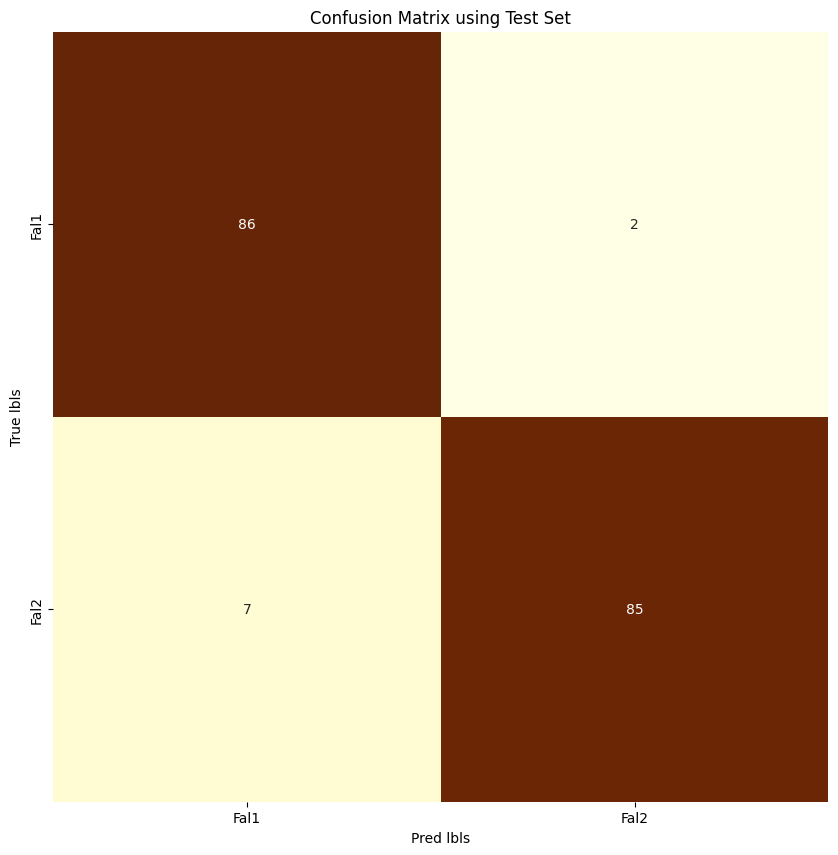

In [45]:
# plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g', 
            xticklabels=class_names, yticklabels=class_names, 
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()

In [46]:
# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [47]:
# displaying testing set counts
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+----------+-----+
| Fal1     |  88 |
+----------+-----+
| Fal2     |  92 |
+----------+-----+
| Test set | 180 |
+----------+-----+


In [48]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s}, 
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
Fal1,92.47%,97.73%,95.03%
Fal2,97.70%,92.39%,94.97%


In [49]:
macro_f1 = round(evals_df['F1'].mean() * 100, 2)
micro_f1 = round(np.sum(cf_matrix.diagonal()) / np.sum(cf_matrix) * 100, 2)
print(f'Macro F1: {macro_f1}%')
print(f'Micro F1: {micro_f1}%')

Macro F1: 95.0%
Micro F1: 95.0%


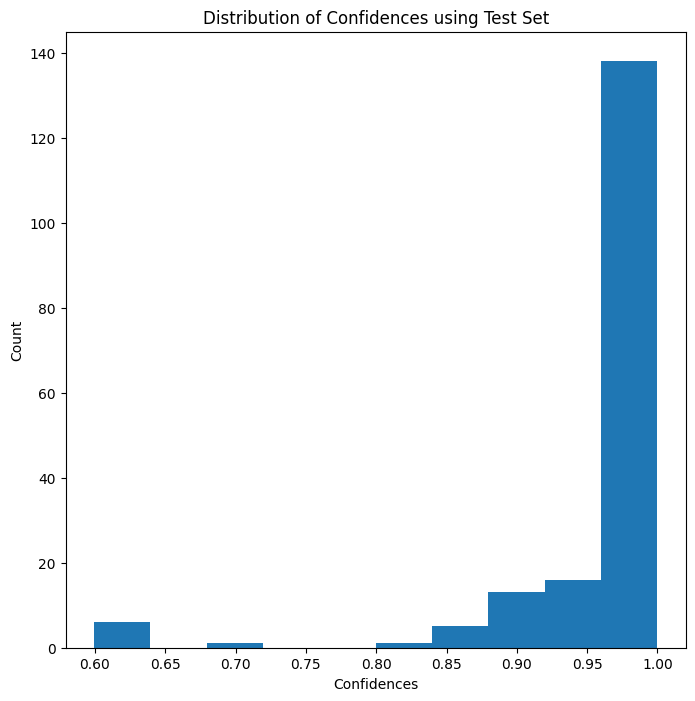

In [50]:
# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

True lbl : Fal2
Pred lbl : Fal2
Conf     : 99.82%


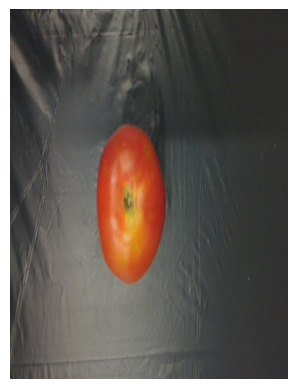

In [54]:
# displaying random image results
rand_batch = random.randint(1, test_size)
rand_img = random.randint(0, BATCH_SIZE - 1)

i = (rand_batch - 1) * BATCH_SIZE
lbl_true_name = lbls_true_names[i:i + BATCH_SIZE][rand_img]
lbl_pred_name = lbls_pred_names[i:i + BATCH_SIZE][rand_img]
pred_conf = pred_confs[i:i + BATCH_SIZE][rand_img]

print(f'True lbl : {lbl_true_name}')
print(f'Pred lbl : {lbl_pred_name}')
print(f'Conf     : {round(100 * pred_conf, 2)}%')

for imgs, lbls in test_set.take(rand_batch):
    plt.imshow(imgs[rand_img].numpy().astype('uint8'))
    plt.axis('off')
    break

### 7. Saving model

In [70]:
# saving latest model
model_ver = len(os.listdir(models_dir)) # latest saved model
model_ver += 1
model.save(f'{models_dir}/{model_ver}')

INFO:tensorflow:Assets written to: C:\Users\ACER1\Music\FruitModel/6\assets


INFO:tensorflow:Assets written to: C:\Users\ACER1\Music\FruitModel/6\assets


In [5]:
#model.save(f'{models_dir}/tomato-disease-detection-model.h5')

In [9]:
import os
import tensorflow as tf

# Load the SavedModel
loaded_model = tf.keras.models.load_model('C:\\Users\\ACER1\\Music\\FruitModel\\6')

# Specify the directory path
save_directory = 'C:\\Users\\ACER1\\Music\\FruitModel\\6'

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save as native Keras format
loaded_model.save(os.path.join(save_directory, 'fruitmodel.keras'))


In [10]:
import tensorflow as tf

# Path to the Keras model in .h5 format
keras_model_path = 'C:\\Users\\ACER1\\Music\\FruitModel\\6\\fruitmodel.keras'

# Path to save the TensorFlow Lite model
tflite_model_path = 'fruit.tflite'

# Load the Keras model from the .h5 file
keras_model = tf.keras.models.load_model(keras_model_path)

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TensorFlow Lite model saved to: {tflite_model_path}')


INFO:tensorflow:Assets written to: C:\Users\ACER1\AppData\Local\Temp\tmp_mm8tjfd\assets


INFO:tensorflow:Assets written to: C:\Users\ACER1\AppData\Local\Temp\tmp_mm8tjfd\assets


TensorFlow Lite model saved to: fruit.tflite
